# Evaluating energies with Matrix Product States

In this How-to we exemplify the Matrix Product State Evaluator.
Specifically, we show how the parameter entering an MPS affect the energy estimate.

## Introduction to Matrix Product States

Given a circuit $U(\theta)$ defined on $N_q$ qubits and acting on the zero state $\vert 0 \rangle^{\otimes N_q}$, the MPS approximation of this circuit is given as:

$$
    U(\theta) \vert 0 \rangle^{\otimes N_q} \approx U_\text{MPS}(\theta) \vert 0 \rangle^{\otimes N_q} 
        = \sum_{\sigma_1,\ldots,\sigma_{N_1}} \sum_{m_1,\ldots,m_{N_q-1}} 
          M_{1,m_1}^{\sigma_1} M_{m_1,m_2}^{\sigma_2} \cdots M_{m_{N_q-1},1}^{\sigma_{N_q}}
          \vert \sigma_1 \cdots \sigma_{N_q} \rangle
$$

In the following we refer to the tensors $M_{m_{i-1}, m_i}^{\sigma_i}$ as "MPS tensors".
The maximum value of the $m_i$ are referred to a "bond dimensions" (more precisely, "bond dimension" is used to indicate the maximum value of $m_i$ over all possible $i$ values).

The MPS representation of a given circuit can be obtained by successively applying the gates entering $U(\theta)$ onto the MPS representation of the circuit.
Note that the initial $\vert 0 \rangle^{\otimes N_q}$ state, being a product state, can be represented as a bond dimension-1 MPS.
Each time a two-qubit gate is applied, the MPS structure is lost as the $M^{\sigma_i}$ tensors associated with two neighbouring qubits are merge together.
The original MPS structure can be retrieved through a singular value decomposition (SVD).
Each SVD truncation step can be approximated by either selecting a maximum allowed value for the bond dimension, or by selecting a threshold below which the singular values are neglected.
Both approaches introduce an approximation.
However, it is known that for circuits with a low-rank structure, a rather tight truncation threshold can be applied without compromising accuracy.

## Implementation details

MPS simulation can be run through the `MPSEvaluator` object, which is implemented in the current library, and can be loaded as shown below.

In [19]:
import matplotlib.pyplot as plt
import time

from qiskit.quantum_info import SparsePauliOp

from qaoa_training_pipeline.evaluation import MPSEvaluator, EfficientDepthOneEvaluator

We now generate a large, 125-node QAOA problem, which we use later to showcase the functionalities of the MPS simulator.

In [20]:
with open("data/125node_example_ising.txt") as input_file:
    paulis = []
    for line in input_file.readlines():
        pauli, coeff = line.split(", ")
        paulis.append((pauli, float(coeff.replace("\n", ""))))
    cost_op = SparsePauliOp.from_list(paulis)

### Depth-one QAOA

First, we perform a depth-one QAOA computation. We obtain the reference energy with the `EfficientDepthOneEvaluator` method, which is specialized for depth-one circuits.

In [21]:
start = time.time()
baseline = EfficientDepthOneEvaluator().evaluate(cost_op, [1, 2])
time_efficient_depth_one = time.time() - start

We now evaluate the cost function with the MPS-based simulator.

Note that: 
 
  - we run two versions of the MPS simulator, one based on the canonical gauge (described [here](https://www.sciencedirect.com/science/article/pii/S0003491610001752)), and one based on the inverse Vidal gauge (described [here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.235123)). As shown in the timing analysis, the second one is preferred because it is faster.

  - for both gauges, we run the simulator by increasing the maximum allowed bond dimension. As shown later, increasing the maximum allowed bond dimension increases the computational cost but, at the same time, the simulation accuracy increases as well.

In [22]:
times_vidal, times_non_vidal = [], []
energy_maps_vidal, energy_maps_non_vidal = [], []

bond_dimension = [2, 4, 8, 16, 32, 64]

truncation_threshold = 1.0e-10

for bd in bond_dimension:

    # Vidal form
    start = time.time()
    energy_maps_vidal.append(
        MPSEvaluator(
            bond_dim_circuit=bd, threshold_circuit=truncation_threshold, use_vidal_form=True
        ).evaluate(cost_op, [1, 2])
    )
    times_vidal.append(time.time() - start)

    # Canonical form
    start = time.time()
    energy_maps_non_vidal.append(
        MPSEvaluator(
            bond_dim_circuit=bd, threshold_circuit=truncation_threshold, use_vidal_form=False
        ).evaluate(cost_op, [1, 2])
    )
    times_non_vidal.append(time.time() - start)

We now plot the results

Text(0, 0.5, 'Wall clock time (sec)')

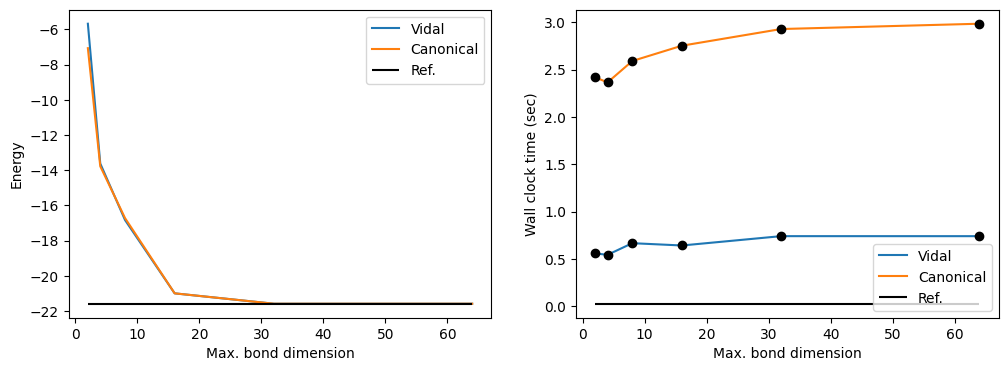

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot of the energy convergence
axs[0].plot(bond_dimension, energy_maps_vidal, label="Vidal")
axs[0].plot(bond_dimension, energy_maps_non_vidal, label="Canonical")
axs[0].hlines(baseline, bond_dimension[0], bond_dimension[-1], "k", label="Ref.")
axs[0].legend()
axs[0].set_xlabel("Max. bond dimension")
axs[0].set_ylabel("Energy")

# Plot of the overall runtime
axs[1].plot(bond_dimension, times_vidal, label="Vidal")
axs[1].plot(bond_dimension, times_non_vidal, label="Canonical")
axs[1].plot(bond_dimension, times_vidal, "ok")
axs[1].plot(bond_dimension, times_non_vidal, "ok")
axs[1].hlines(time_efficient_depth_one, bond_dimension[0], bond_dimension[-1], "k", label="Ref.")
axs[1].legend()
axs[1].set_xlabel("Max. bond dimension")
axs[1].set_ylabel("Wall clock time (sec)")

As expected, by increasing the bond dimension, the accuracy of the energy estimates becomes increasingly more accurate.

Moreover, as anticipated, the Vidal-based implementation is faster than the Canonical one.

Both simulations are slower than the one ran with the `EfficientDepthOne` method.
This is due to the fact that MPS-based simulations come with an overhead associated with the fact that complex data structure needs to be created (e.g., to store the MPS) and manipulated.
For deeper circuit, this overhead becomes negligible, and MPS-based simulation are much more efficient than alternative, exact methods. 

## Depth-two QAOA

We now extend the previous analysis to a depth-2 circuit.

Increasing the depth increases the circuit complexity and, consequently, a higher bond dimension will be required for the circuit simulation.

In this case, we will use the light-cone estimator for generating reference data.

In [24]:
from qaoa_training_pipeline.evaluation import LightConeEvaluator

parameters = [0.1, 0.2, -0.3, 0.4]

start = time.time()
baseline = LightConeEvaluator().evaluate(cost_op, parameters)
time_light_cone = time.time() - start

Given the previous results, we use here the Vidal gauge.
Moreover, instead of changing the maximum allowed bond dimension, we change the truncation threshold in the MPS simulation.
Remember that more accurate simualtions are expected with a lower truncation threshold.

In [25]:
truncation_thresholds = [1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5]

energy_mps = []
time_mps = []

for threshold in truncation_thresholds:
    start = time.time()
    energy_mps.append(
        MPSEvaluator(use_vidal_form=True, threshold_circuit=threshold).evaluate(cost_op, parameters)
    )
    time_mps.append(time.time() - start)

As above, we plot the results taking the light-cone data as reference.

Text(0, 0.5, 'Wall clock time (sec)')

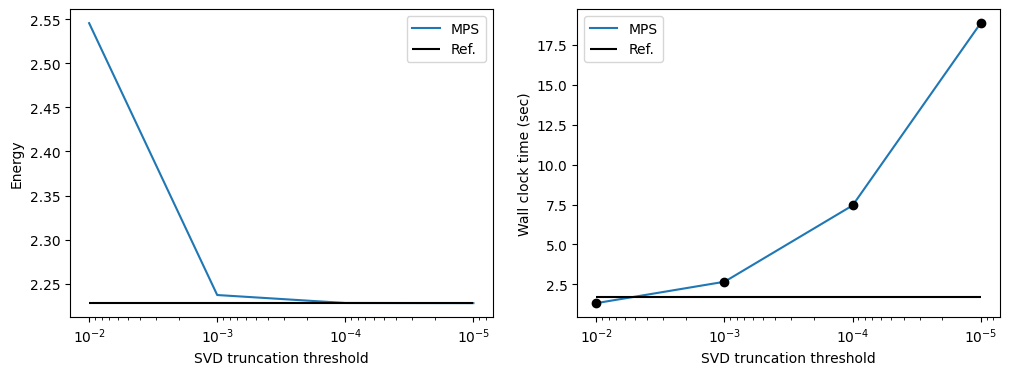

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot of the energy convergence
axs[0].plot(truncation_thresholds, energy_mps, label="MPS")
axs[0].hlines(baseline, truncation_thresholds[0], truncation_thresholds[-1], "k", label="Ref.")
axs[0].legend()
axs[0].invert_xaxis()
axs[0].set_xscale("log")
axs[0].set_xlabel("SVD truncation threshold")
axs[0].set_ylabel("Energy")

# Plot of the overall runtime
axs[1].plot(truncation_thresholds, time_mps, label="MPS")
axs[1].plot(truncation_thresholds, time_mps, "ok")
axs[1].hlines(
    time_light_cone, truncation_thresholds[0], truncation_thresholds[-1], "k", label="Ref."
)
axs[1].legend()
axs[1].invert_xaxis()
axs[1].set_xscale("log")
axs[1].set_xlabel("SVD truncation threshold")
axs[1].set_ylabel("Wall clock time (sec)")

Note that, with a truncation threhsold of $10^{-4}$ the energy is virtually undistinguishable from the exact one, obtained with the light-cone evaluator.

## Training with MPS-based simulators

We show here below how an `MPSEvaluator` object can be used also to train a QAOA circuit.
We consider, for simplicitly, the depth-one case.

Different training methods are implemented in the library, such as the [Trotterized Quantum Annealing](https://quantum-journal.org/papers/q-2021-07-01-491/) or the [transition state trainer](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.062404).
In the example reported here below, we instead use the `ScipyTrainer`, which uses `COBYLA` as implemented in `SciPy`.
The trainer object takes as input the evaluator to be used for the QAOA energy evaluation.
The `train` method can be run on the resulting object, by speciftying the cost operator (from which the number of qubits is extracted) and the initial parameters (from which the number of layers is extracted).

In [27]:
from qaoa_training_pipeline.evaluation import MPSEvaluator
from qaoa_training_pipeline.training import ScipyTrainer

mps_evaluator = MPSEvaluator(
    use_vidal_form=True, threshold_circuit=1.0e-4, store_schmidt_values=True
)
trainer_mps = ScipyTrainer(mps_evaluator)
result_mps = trainer_mps.train(cost_op, [0.5, 0.2])

The `result` dictionary contains relevant informations about the optimization data as the optimal parameters, the circuit energy, and the optimization trajectory. If the optional argument `store_schmidt_values` is set to `True`, also the Schmidt values are stored along the propagation. This information can be used to estimate the accuracy of the MPS optimization as suggested [here](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.10.041038).

In [28]:
result_mps.keys()

dict_keys(['status', 'success', 'message', 'nfev', 'maxcv', 'optimized_params', 'energy', 'x0', 'train_duration', 'trainer', 'energy_history', 'parameter_history', 'circuit_bond_dimension', 'schmidt_values'])

(0.0, 35.0)

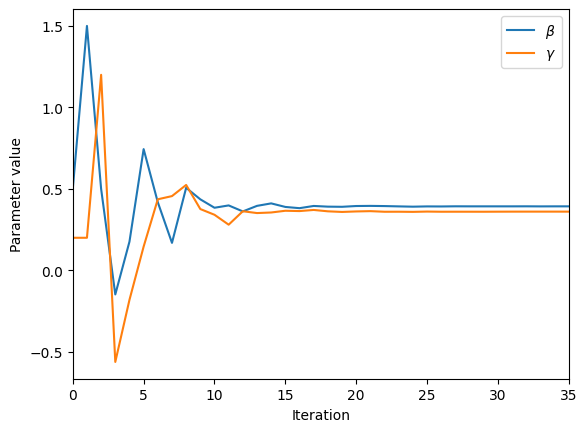

In [29]:
import matplotlib.pyplot as plt

parameter_0_value = [i[0] for i in result_mps["parameter_history"]]
parameter_1_value = [i[1] for i in result_mps["parameter_history"]]
x_values = range(len(parameter_0_value))

plt.plot(x_values, parameter_0_value, label=r"$\beta$")
plt.plot(x_values, parameter_1_value, label=r"$\gamma$")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Parameter value")
plt.xlim([0, 35])

We can run the same optimization with the `EfficientDepthOne` evaluator.

In [30]:
from qaoa_training_pipeline.evaluation import EfficientDepthOneEvaluator
from qaoa_training_pipeline.training import ScipyTrainer

trainer_depth_one = ScipyTrainer(EfficientDepthOneEvaluator())
result_depth_one = trainer_depth_one.train(cost_op, [0.5, 0.2])

As expected, the two trainers return the same energy and parameters.

In [31]:
result_depth_one["optimized_params"]

[0.39268721903755954, 0.36024643400433537]

In [32]:
result_mps["optimized_params"]

[0.39268721883096014, 0.3602464340490598]